In [1]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import math
from importlib import reload
from scipy.io import savemat
import time
from matplotlib.pyplot import figure
import imageio

import matplotlib.pyplot as plt
import ParticleFilter
import Poisson_Tree_Particle_Filter

reload(ParticleFilter)
reload(Poisson_Tree_Particle_Filter)

from numpy.random import choice, poisson, gamma, normal
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import bernoulli, gamma

from Tree_Node import *

seed = 17

# Data

In [24]:
def get_s_1(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    
    return s_0 + v_0*dt + (1/2)*a_0*(dt**2)

def get_v_1(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    
    return v_0 + a_0*dt

In [25]:
def generate_data(n_res, res, sigma_theta, s_x_0, v_x_0, s_y_0, v_y_0, gamma_shape=2, gamma_scale=1, seed=0):
    np.random.seed(seed)
    
    #generate tau
    tau = [0]
    
    while tau[-1] < n_res*res:
        tau.append(tau[-1] + np.random.gamma(shape=gamma_shape, scale=gamma_scale))

    _ = tau.pop()
    tau = np.array(tau)
    kT = len(tau)
    
    #generate acceleration at tau
    a_x_tau = np.random.normal(loc=0.0, scale=sigma_theta, size=kT)
    a_y_tau = np.random.normal(loc=0.0, scale=sigma_theta, size=kT)
           
    #compute states variables at tau
    s_x_tau, v_x_tau, = np.empty(kT), np.empty(kT)
    s_y_tau, v_y_tau, = np.empty(kT), np.empty(kT)
        
    s_x_tau[0], v_x_tau[0] = s_x_0, v_x_0
    s_y_tau[0], v_y_tau[0] = s_y_0, v_y_0
    
    for i1 in range(1, kT):
        i0 = i1 - 1
        s_x_tau[i1] = get_s_1(
            s_0=s_x_tau[i0],
            v_0=v_x_tau[i0],
            a_0=a_x_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        s_y_tau[i1] = get_s_1(
            s_0=s_y_tau[i0],
            v_0=v_y_tau[i0],
            a_0=a_y_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        v_x_tau[i1] = get_v_1(
            v_0=v_x_tau[i0],
            a_0=a_x_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
        v_y_tau[i1] = get_v_1(
            v_0=v_y_tau[i0],
            a_0=a_y_tau[i0],
            t_0=tau[i0],
            t_1=tau[i1],
        )
    
    
    #compute path/trajectory
    s_x, s_y = np.empty(n_res+1), np.empty(n_res+1)
    
    s_x[0], s_y[0] = s_x_0, s_y_0
    
    tau_index = 0
    for i in range(1, n_res+1):
        t = i*res
        
        #find last tau before this t
        while t > tau[tau_index]:
            tau_index += 1
        
            if tau_index == kT:
                break
            
        tau_index -= 1
        
        #compute coordinates at t
        s_x[i] = get_s_1(
            s_0=s_x_tau[tau_index],
            v_0=v_x_tau[tau_index],
            a_0=a_x_tau[tau_index],
            t_0=tau[tau_index],
            t_1=t,
        )
        s_y[i] = get_s_1(
            s_0=s_y_tau[tau_index],
            v_0=v_y_tau[tau_index],
            a_0=a_y_tau[tau_index],
            t_0=tau[tau_index],
            t_1=t,
        )
                
    return s_x_tau, s_y_tau, s_x, s_y, tau

In [26]:
def generate_observations(delta_t, res, mean, std, x, y):   
    step = int(delta_t / res)
    x_noisy, y_noisy = x[::step] + np.random.normal(mean, std, x[::step].size), y[::step] + np.random.normal(mean, std, y[::step].size)
    
    return x_noisy, y_noisy

In [27]:
#%%script false --no-raise-error

T = 200
delta_t = 5
res = 1       #resolution for plotting hidden process

n_res = int(T / res)
n = int(T / delta_t)

sigma_theta = 5.0
sigma_obs = 200.0

gamma_shape = 10.0
gamma_scale = 2.5

lam = scipy.stats.gamma.cdf(delta_t, gamma_shape, scale=gamma_scale)
lam = T / (gamma_shape*gamma_scale*n)
print(lam)

s_x_0, s_y_0 = 64000, 29000
v_x_0, v_y_0 = 400, 0

0.2


In [28]:
s_x_tau, s_y_tau, s_x, s_y, tau= generate_data(
    n_res,
    res,
    sigma_theta,
    s_x_0=s_x_0,
    s_y_0=s_y_0,
    v_x_0=v_x_0,
    v_y_0=v_y_0,
    gamma_shape=gamma_shape,
    gamma_scale=gamma_scale,
    seed=seed
)

x_obs, y_obs = generate_observations(delta_t, res, mean=0.0, std=sigma_obs, x=s_x, y=s_y)

# mixture kernels 

In [29]:


#for i in [5, 15, 25, 35]:
#    x_obs[i] = s_x[::step][i] + normal(0, 2500)
#    y_obs[i] = s_y[::step][i] + normal(0, 2500)


In [30]:
def get_space(s_0, v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return s_0 + v_0 * dt + (1 / 2) * a_0 * (dt ** 2)

def get_velocity(v_0, a_0, t_0, t_1):
    dt = t_1 - t_0
    return v_0 + a_0 * dt

def get_temporary_position(j, current_t, particles, delta_t):
    x_temp = get_space(particles[current_t][j].get_sx(), particles[current_t][j].get_vx(), particles[current_t][j].get_ax(), particles[current_t][j].get_tau(), current_t * delta_t)
    y_temp = get_space(particles[current_t][j].get_sy(), particles[current_t][j].get_vy(), particles[current_t][j].get_ay(), particles[current_t][j].get_tau(), current_t * delta_t)
    return x_temp, y_temp
    

def get_likelihood(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    pobsx_given_x, pobsy_given_y = norm.pdf(x_temp, x_obs, sigma_obs), norm.pdf(y_temp, y_obs, sigma_obs) 
    return pobsx_given_x * pobsy_given_y

def logLikelihood(x, mu, sigma):
    return - (1 / 2) * np.log(2*np.pi) - (1 / 2) * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * (x - mu)**2

def log_weights(x_temp, x_obs, y_temp, y_obs, sigma_obs):
    loglikelihood_x = logLikelihood(x_temp, x_obs, sigma_obs)
    loglikelihood_y = logLikelihood(y_temp, y_obs, sigma_obs)
    return loglikelihood_x + loglikelihood_y
    
def init_particles(lam, num_particles, delta_t, particles, sigma_theta):
    for j in range(num_particles):
        sx, sy = s_x_0, s_y_0
        vx, vy = v_x_0, v_y_0
        ax, ay = np.random.normal(0, sigma_theta), np.random.normal(0, sigma_theta) 
        tau =  0
        particles[0].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None, 1))
    return particles


                        
def multiple_birth_move(current_t, j, particles, sigma_theta):
    k_new = 1
    #k_new = 2*np.ones(n)
    
    #ts = particles(j,tau,k(j)) + delta_t*rand(1,k_new(j));
  
    tau = particles[current_t - 1][j].get_tau() + ((current_t) * delta_t - particles[current_t - 1][j].get_tau())*np.random.uniform(0, 1, k_new)
 
    ax = np.random.normal(0, sigma_theta)
    ay = np.random.normal(0, sigma_theta)
    sx = get_space(particles[current_t - 1][j].get_sx(), particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    sy = get_space(particles[current_t - 1][j].get_sy(), particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau)
    vx = get_velocity(particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    vy = get_velocity(particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau) 

    particles[current_t].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 1][j]))
    particles[current_t - 1][j].add_child_node(particles[current_t][j])
    
    return particles
    
    
def resample(current_t, weights, num_particles):
    
    M = len(weights)
    
    ni = np.random.permutation(M)
    weights = weights[ni]
    
    inds = np.zeros(num_particles)
    
    weights = weights/np.sum(weights)
    cdf = np.cumsum(weights)
    
    cdf[-1] = 1
    
    p = np.linspace(np.random.uniform(0, 1) * (1 / num_particles), 1, num_particles)
    picked = np.zeros(M)
                    
    j=0
    for i in range(num_particles):
        while (j < M) & (cdf[j] < p[i]):
            j += 1
        picked[j] += 1
    
    rind = 0
    for i in range(M):
        if picked[i] > 0:
            for j in range(int(picked[i])):
                inds[rind] = int(ni[i])
                rind = rind + 1
                
    return inds.astype(int)

def adjust_move(current_t, j, particles, sigma_adjust):
    #new tau
    tau = -1
    while tau < 0:
        tau = np.random.normal(particles[current_t - 1][j].get_tau(), sigma_adjust)
    if tau <= 0:
        print(tau, j, t, 'adjust')
    #evaluate x and v in the new tau
    ax = particles[current_t - 1][j].get_ax()
    ay = particles[current_t - 1][j].get_ay()
    sx = get_space(particles[current_t - 1][j].get_sx(), particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    sy = get_space(particles[current_t - 1][j].get_sy(), particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau)
    vx = get_velocity(particles[current_t - 1][j].get_vx(), particles[current_t - 1][j].get_ax(), particles[current_t - 1][j].get_tau(), tau)
    vy = get_velocity(particles[current_t - 1][j].get_vy(), particles[current_t - 1][j].get_ay(), particles[current_t - 1][j].get_tau(), tau) 

    
    if current_t == 1:
        particles[current_t - 1][j] = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None)
    else :
        particles[current_t - 1][j] = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 2][j])
    particles[current_t].append(Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], particles[current_t - 1][j]))
    particles[current_t - 1][j].add_child_node(particles[current_t][j])
    
    return particles
                    

def compute_survivor_probability(current_t, num_particles, delta_t, particles, gamma_shape, gamma_scale):
    p = np.zeros(num_particles)
    
    for j in range(num_particles):
        p[j] = gamma.cdf(current_t* delta_t - particles[current_t - 1][j].get_tau(), gamma_shape, gamma_scale) - gamma.cdf(0, gamma_shape, gamma_scale)
        #print(p[j], particles['tau'][j, k[j]-1])
    S = np.ones(num_particles) - p
    
    return S
    
 

In [31]:
%%time

filenames = []
x_saved, y_saved = [], []


num_particles = 1000
sigma_obs = 1000

gamma_shape = gamma_shape 
gamma_scale = gamma_scale 

sigma_theta = sigma_theta 

x_obs, y_obs = np.insert(x_obs, 0, 64000), np.insert(y_obs, 0, 29000)
step = int(delta_t / res)

sigma_adjust = delta_t / 1000
capacity = n*3
weights = np.ones(num_particles) / np.sum(np.ones(num_particles))
log_weights = np.zeros(num_particles)
store_weights = np.zeros([num_particles, n + 2])

particles =  []

capacity = 500
expectation_x,  expectation_y = np.zeros(n + 2), np.zeros(n + 2)

num_unique_particles_pre = np.zeros(n + 2)
num_unique_particles_post = np.zeros(n + 2)
x_temp, y_temp = np.zeros([num_particles, n + 2]), np.zeros([num_particles, n + 2])
ess = np.zeros(n + 2)

particles.append([])
particles = init_particles(lam, num_particles, delta_t, particles, sigma_theta)
for t in range(1, n + 2):
    
    particles.append([])
    
    if t == 1:
        alpha = np.zeros(num_particles)
    else:
        S = compute_survivor_probability(t, num_particles, delta_t, particles, gamma_shape, gamma_scale)
        alpha = np.random.binomial(1, S, size = num_particles)
    
    #print(S, alpha)
    #self.birth_move(t)
    for j in range(num_particles):
        
        if alpha[j] == 1:
            x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t-1, particles, delta_t)
        
            prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs) 
            
            particles = adjust_move(t, j, particles, sigma_adjust)
            x_temp[j, t], y_temp[j, t] = get_temporary_position(j, t, particles, delta_t)
                                                                                                       
            curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
            weights[j] = curr_likelihood
            
            particles[t][j].set_weight(weights[j])
            
            #if (prev_likelihood * S[j] != 0):
            #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * S[j])
            #else:
            #    weights[j] = (curr_likelihood * 1/2)
        
        else:
                
            x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t-1, particles, delta_t)
            
            prev_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            particles = multiple_birth_move(t, j, particles, sigma_theta)
            x_temp[j, t],  y_temp[j, t] = get_temporary_position(j, t, particles, delta_t)
            
            curr_likelihood = get_likelihood(x_temp[j, t], x_obs[t], y_temp[j, t], y_obs[t], sigma_obs)
            
            weights[j] = curr_likelihood
            
            particles[t][j].set_weight(weights[j])
            #weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))

            #if (prev_likelihood * (1 - S[j]) != 0) and ((t+1) * delta_t - particles['tau'][j, k[j]-1] != 0):
            #    weights[j] = (curr_likelihood * 1/2) / (prev_likelihood * (1 - S[j]) * (1 / ((t+1)*delta_t - particles['tau'][j, k[j]-1])))
            #else:
            #    weights[j] = curr_likelihood * 1 / 2
    #print(particles['tau'][:, k[9]])
    
    if (np.sum(weights[:]) != 0):
        weights = weights / np.sum(weights)
    #print(weights)
    store_weights[:, t] = weights 
        
    expectation_x[t] = np.matmul(weights, x_temp[:, t])
    expectation_y[t] = np.matmul(weights, y_temp[:, t])
    
    if np.sum(weights**2) != 0:
        ess[t] = 1/np.sum(weights**2)
        if (ess[t] < 0.5*num_particles) & (t < n) :
            num_unique_particles_pre[t] = num_unique_particles_post[t - 1]
            inds = resample(t, weights, num_particles)
            num_unique_particles_post[t] = len(np.unique(inds))
            particles[t] = np.array(particles[t])[inds]
            weights = np.ones(num_particles) / np.sum(np.ones(num_particles))  
        else : 
            num_unique_particles_post[t] = num_unique_particles_post[t - 1]
            num_unique_particles_pre[t] = num_unique_particles_pre[t - 1]
    else:
        num_unique_particles_post[t] = num_unique_particles_post[t - 1]
        num_unique_particles_pre[t] = num_unique_particles_pre[t - 1]
        
x_saved.append(x_temp)
y_saved.append(y_temp)
    

Wall time: 30.2 s


In [32]:
filenames_old = filenames  
filenames = filenames[0:4]
with imageio.get_writer('mygif_dist.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
    

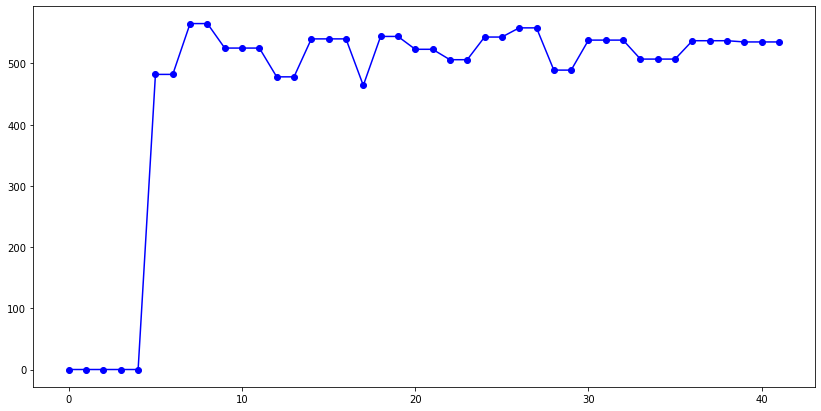

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(num_unique_particles_post, 'b', marker='o')
plt.savefig('num_uniq_particles.png')

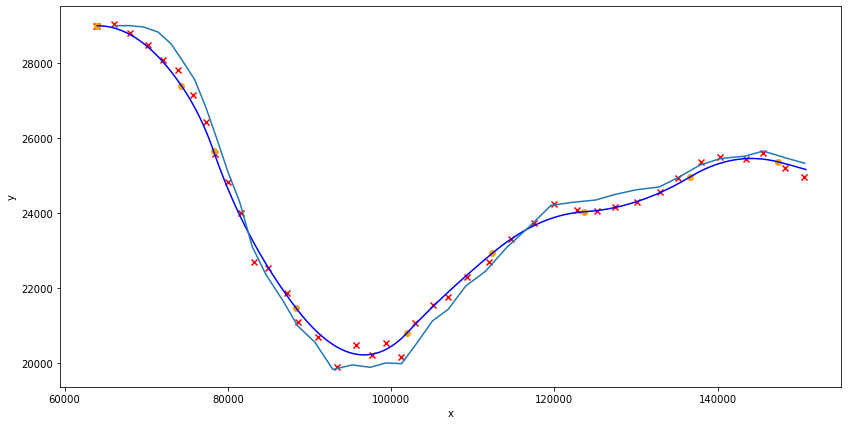

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(s_x, s_y, color='blue', label='hidden process')
plt.scatter(x_obs, y_obs, marker='x', color='red', label='observations')
plt.scatter(s_x_tau, s_y_tau, marker='o', color='orange', label='jump locations')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(expectation_x[1:], expectation_y[1:], label='estimated trajectory')

plt.savefig('pdp_pf_avg_outliers.eps')

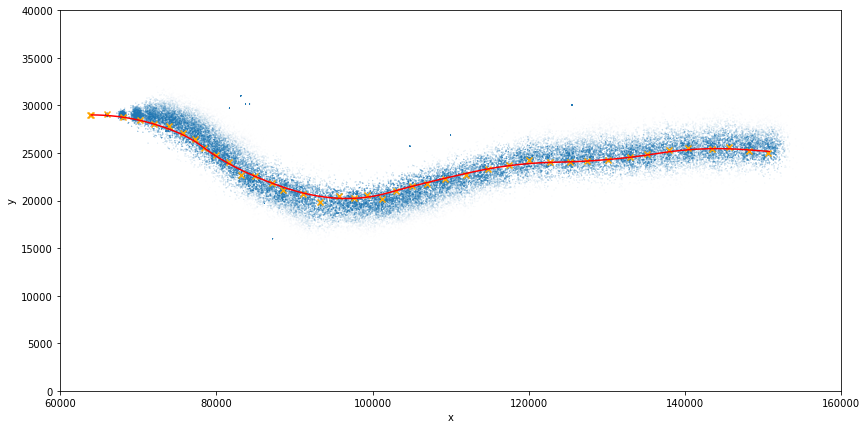

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(s_x, s_y, color='red', label='hidden process')
plt.scatter(x_temp, y_temp, s= store_weights*20)
plt.scatter(x_obs, y_obs, marker='x', color='orange', label='observations')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(60000, 160000)
plt.ylim(0, 40000)

plt.savefig('pdppf_distrib.eps')

In [36]:
x_temp_pd, y_temp_pd =  x_temp, y_temp

# PTPF

In [15]:
np.random.seed(seed)

In [16]:
def init_particles(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles):
    for j in range(num_particles):
        sx, sy = s_x_0, s_y_0
        vx, vy = v_x_0, v_y_0
        ax, ay = np.random.normal(0, sigma_theta), np.random.normal(0, sigma_theta)  # this acceleration should not be needed 
        tau =  0
        particle = Tree_Node(tau, [sx, sy], [vx, vy], [ax, ay], None, 0, 0, 0, 0)
        V_act.append(particle)
        nodes_set.add(particle)
    return V_act, nodes_set

In [17]:
%%time

num_particles = 20000
lambda_0 = 50
delta_t_syn = delta_t * 4

sigma_obs = 1000
gamma_shape = gamma_shape / 2
gamma_scale = gamma_scale / 2
b0 = 1
T_end = 120
num_part = int(T_end / delta_t_syn)
num_obs_per_interval = int(delta_t_syn / delta_t)
#print(num_obs_per_interval)
nodes_set = set()
V_act = []
V_end = []
prob_end = []
W_r0 = np.zeros(num_part + 1)
Gr_count = np.zeros(num_part + 1)
AS = False
        
keys = np.array(range(num_part + 1))
        
Fr = {k: [] for k in keys}
Fr_weights = {k: [] for k in keys}

V_act, nodes_set = init_particles(s_x_0, s_y_0, v_x_0, v_y_0, sigma_theta, gamma_shape, gamma_scale, V_act, nodes_set, num_particles)
V_init = V_act.copy()

Wall time: 330 ms


In [18]:
%%time   

while V_act:
    particle = V_act[0]
    
    if particle.get_parent() == None:
        Lambda = lambda_0
        particle.set_C(lambda_0)
        
    else:  # we now compute Lambda: in this case I call Lambda the intensity parameter multiplied my the weight
        
        if particle.get_in_F_r0() == 1:
            t_r = particle.get_t_r() 

            if (particle.get_W_ri() != 0.0) and (particle.get_W_ri() != 1.0):
                Lambda = (particle.get_W_ri() / W_r0[t_r]) * np.maximum(lambda_0 - Gr_count[t_r], b0) * 10
                #print(particle.get_W_ri(), W_r0[t_r], Gr_count[t_r], t_r)
                
                #Lambda = (0.1) * np.maximum(lambda_0 - Gr_count[t_r], b0) 
                #print(particle.get_W_ri() / W_r0[t_r], particle.get_W_ri(), W_r0[t_r])
                #Lambda = 1
                
            else :
                Lambda = 0
            #print(particle.get_W_ri(), W_r0[t_r], t_r, Lambda, particle.get_weight())

        else:
                
            Lambda = 1
        
        #if  (t_r > 0):
        #    if AS & (np.sum(Fr_weights[t_r - 1]) != 0):
        #        new_parent_index = choice(a = (np.array(range(len(Fr_weights[t_r - 1])))), size = 1, p = (Fr_weights[t_r - 1] / np.sum(Fr_weights[t_r - 1]) ))
    #
        #        new_parent = Fr[int(t_r - 1)][int(new_parent_index)]
        #        particle.set_parent(new_parent)
        # 
            
        parent = particle.get_parent()
        
        #particle.set_C(Lambda / particle.get_weight() * parent.get_C())
        #if particle.get_weight() != 0:
        #    particle.set_C((Lambda / particle.get_weight())* parent.get_C())
        #    print(particle.get_C())
        #else:
        #    particle.set_C(Lambda * parent.get_C())
    
    if (Lambda < 0) or (math.isnan(Lambda)):
        N = 0
    else:
        #print(Lambda)
        N = poisson(Lambda)
    
    if N > 0:
        for _ in range(N):
            tau = particle.get_tau() + np.random.gamma(shape=gamma_shape, scale=gamma_scale)
            
            t_r = int(tau // int(delta_t_syn))  #get last t_syn 
            if t_r > num_part:
                t_r = num_part
            ax, ay = normal(0, sigma_theta), normal(0, sigma_theta)
            #parent = particle.get_parent()
            #if parent == None:
            #    parent_tau = 0
            #else:
            #    parent_tau = particle.get_parent().get_tau()

            sx = get_space(particle.get_sx(), particle.get_vx(), ax, particle.get_tau(), tau)
            sy = get_space(particle.get_sy(), particle.get_vy(), ay, particle.get_tau(), tau)
            vx = get_velocity(particle.get_vx(), ax, particle.get_tau(), tau)
            vy = get_velocity(particle.get_vy(), ay, particle.get_tau(), tau)
            
            t_obs_prec = int(tau // int(delta_t))  #get index of last obs
            if t_obs_prec > n:
                t_obs_prec = n
            
            num_t_syn = t_r - particle.get_t_r()
            num_obs = t_obs_prec - particle.t_obs_prec
            likelihood = 1
            W_ri = 1
            
            # compute W_ri, W_r0 and G_r0 
            if num_t_syn > 0:
                if num_t_syn > 2:
              
                    for i in range(1, int(num_t_syn)):
                        Gr_count[int(t_r - i)] += 1
                        
                t_obs = (t_r - 1) * num_obs_per_interval
                
                for obs in range(num_obs_per_interval):
                    x_temp = get_space(sx, vx, ax, particle.get_tau(), t_obs * delta_t)
                    y_temp = get_space(sy, vy, ay, particle.get_tau(), t_obs * delta_t)
                    W_ri_temp = get_likelihood(x_temp, x_obs[int(t_obs)], y_temp, y_obs[int(t_obs)],sigma_obs)
                    #if W_ri_temp != 0.0:
                    W_ri *= W_ri_temp
                    t_obs += 1
                
                if W_ri != 1.0:
                    W_r0[int(t_r)] += W_ri
                    #print(W_r0[int(t_r)], W_ri, t_r)
                    in_F_r0 = 1
                else:
                    in_F_r0 = 0
               
            else:
                in_F_r0 = 0
                
            for i in range(int(particle.t_obs_prec) + 1, int(t_obs_prec + 1)):
                
                x_temp = get_space(sx, vx, ax, i*delta_t, particle.get_tau())
                y_temp = get_space(sy, vy, ay, i*delta_t, particle.get_tau())
                
                if i == int(particle.t_obs_prec) + 1:
                    likelihood_temp = get_likelihood(x_temp, x_obs[i], y_temp, y_obs[i], sigma_obs)
                    #if likelihood_temp != 0:
                    likelihood = likelihood_temp 
                else:
                    likelihood_temp =  get_likelihood(x_temp, x_obs[i], y_temp, y_obs[i], sigma_obs)
                    #if likelihood_temp != 0:
                    likelihood = likelihood * likelihood_temp
                        
            if (likelihood != 0) & (likelihood != 1):
                if in_F_r0 == 1:
                    child = Tree_Node (tau, [sx, sy], [vx, vy], [ax, ay], particle, likelihood, in_F_r0, t_r, t_obs_prec, W_ri)
                elif in_F_r0 == 0:
                    child = Tree_Node (tau, [sx, sy], [vx, vy], [ax, ay], particle, likelihood, in_F_r0, t_r, t_obs_prec)
            
                
                Fr[t_r].append(child)
                Fr_weights[t_r].append(child.get_weight())
                particle.add_child_node(child)
                
                if tau > T_end:
                    V_end.append(child)
                    prob_end.append(child.get_weight())# / particle.get_C())
                else:
                    V_act.append(child)
            
    V_act.remove(particle)

Wall time: 28min


In [19]:
states_obs_time_x = np.zeros([len(V_end), n])
states_obs_time_y = np.zeros([len(V_end), n])

weights_obs = np.zeros([len(V_end), n])
exp_x = np.zeros(n)
exp_y = np.zeros(n) 

    
count = 0
for V in V_end:
    temp_x = np.zeros(n)
    temp_y = np.zeros(n)
    temp_w = np.zeros(n)
    
    current_node = V
    while current_node != None:
        parent = current_node.get_parent()
        
        if parent != None:
            t_obs = int(current_node.get_tau() // delta_t)
            t_obs_parent = int(parent.get_tau() // delta_t)
            
            if t_obs_parent > n:
                t_obs_parent = n
                
            if t_obs > n:
                t_obs = n
            
            #print(t_obs_parent + 1, t_obs + 1)
            for obs in range(t_obs_parent + 1, t_obs + 1):
                temp_x[obs - 1] = get_space(parent.get_sx(), parent.get_vx(), current_node.get_ax(), parent.get_tau(), obs*delta_t)
                temp_y[obs - 1] = get_space(parent.get_sy(), parent.get_vy(), current_node.get_ay(), parent.get_tau(), obs*delta_t)
                temp_w[obs - 1] = get_likelihood(temp_x[obs - 1], x_obs[obs - 1], temp_y[obs - 1], y_obs[obs - 1], sigma_obs)
                #print(temp_x[obs - 1], temp_y[obs - 1])
                
            #print(t_obs_parent + 1, t_obs + 1)
        
        current_node = parent
    states_obs_time_x[count, :] = temp_x
    states_obs_time_y[count, :] = temp_y
    weights_obs[count, :] = temp_w 
    
    count += 1

# Plots PFs

# X axis 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


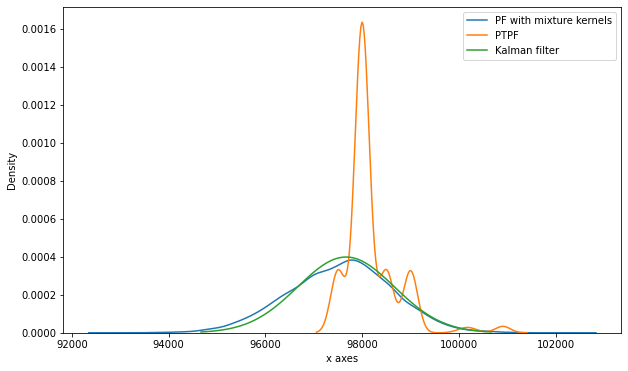

In [20]:
mu = x_obs[19]
variance = 1000000
sigma = math.sqrt(variance)

figure(figsize=(10, 6))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
sns.kdeplot(x_temp_pd[:, 19], label='PF with mixture kernels')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='Kalman filter')
plt.xlabel('x axes')
plt.legend()
plt.savefig('conv_trag_pf_x.eps')
plt.show()


# Y axis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


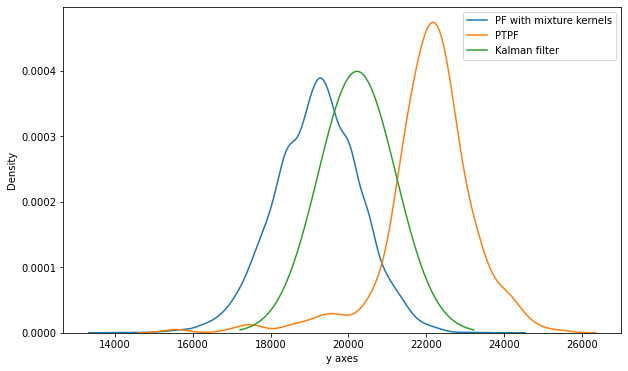

In [21]:
mu = y_obs[19]
variance = 1000000
figure(figsize=(10, 6))
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
sns.kdeplot(y_temp_pd[:, 19], label='PF with mixture kernels')
sns.kdeplot(states_obs_time_y[:, 23] + 3000, label='PTPF')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='Kalman filter')
plt.legend()
plt.xlabel('y axes')
plt.savefig('conv_trag_pf_y.eps')
plt.show()

# Parameters 

In [22]:
taus_smc2 = pd.read_csv('smc2_mk.csv', names=['tau'], on_bad_lines='skip')
taus_pg_ptpf = pd.read_csv('gibbs_ptpf.csv', names=['tau'])
taus_pg_mk = pd.read_csv('gibbs_mk.csv', names=['tau'], on_bad_lines='skip')

In [23]:
taus_smc2

,tau
0,65.0
1,55.0
2,23.0
3,2.0
4,86.0
...,...
9913,16.0
9914,15.0
9915,28.0
9916,58.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


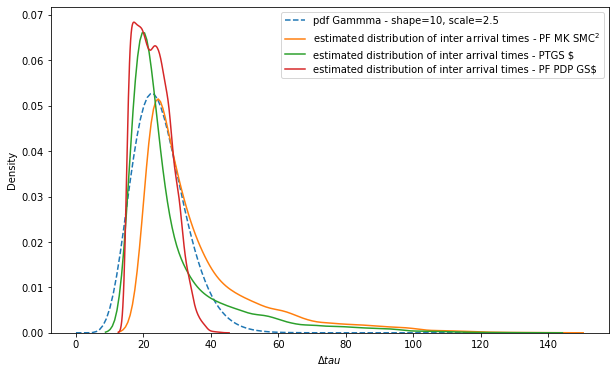

In [24]:
import scipy.stats as stats
figure(figsize=(10, 6))
x = np.linspace (0, 150, 150) 

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=10, scale=2.5)

#create plot of Gamma distribution
plt.plot(x, y, '--', label='pdf Gammma - shape=10, scale=2.5')

sns.kdeplot(taus_smc2['tau'], label = 'estimated distribution of inter arrival times - PF MK SMC$^2$')
sns.kdeplot(taus_pg_ptpf['tau'], label = 'estimated distribution of inter arrival times - PTGS $')
sns.kdeplot(taus_pg_mk['tau'], label = 'estimated distribution of inter arrival times - PF PDP GS$')
plt.legend()
plt.xlabel('$\Delta tau$')

plt.savefig('distrib_gamma.eps')

# Num unique traj

In [27]:
num_unique_trajectories_pf = pd.read_csv('num_unique_trajectories_pf.csv', names=['num'], on_bad_lines='skip')
num_unique_trajectories = pd.read_csv('num_unique_trajectories.csv', names=['num'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


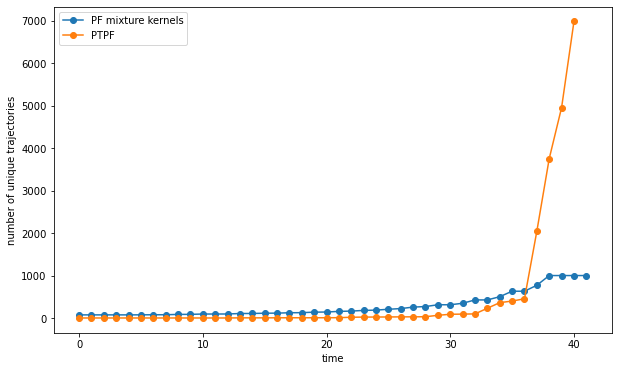

In [28]:
t = np.array(range(len(num_unique_trajectories)))
figure(figsize=(10, 6))
plt.plot(num_unique_trajectories_pf['num'], marker='o', label='PF mixture kernels')
plt.plot(t, num_unique_trajectories['num'], marker='o', label='PTPF')
plt.legend()
plt.xlabel('time')
plt.ylabel('number of unique trajectories')

plt.savefig('uniq_traj.png')